# Quantum Polar Decoding
This file demonstrates the algorithm explained in our paper **"Quantum Channel Decoding"** as submitted to the [QEC-22 conference](https://qce.quantum.ieee.org/2022/).

Please refer to the readme file in the root of this repo for more information about setting up the environment, installing the required packages, and getting ready to run this notebook.

Copyright &copy; 2022 InterDigital AI Research Lab

In [1]:
import numpy as np
from qiskit.visualization import plot_histogram

from quantumpolardecoder import QuantumPolar
from polarsc import scDecode, sclDecode

## Creating a QuantumPolar class
Here we first create a ``QuantumPolar`` class for (16,8) Polar Decoding, which means we are using 8-bit messages embedded in 16-bit code-words. The ``getRandomMessage`` method creates a random message and returns it together with the corresponding code-word, BPSK-modulated signal, and noisy received signal. 

Then we print the message information before calling a series of decoding functions to decode the noisy received signal using **Successive Cancellation**, **Successive Cancellation List**, and **Quantum** algorithms.

For a more realistic experience, you can use the ``FakeMontreal`` simulator which uses a noise model generated based on a real quantum computer (in this case IBMQ's "Montreal" quantum computer with 27 qubits).

In [2]:
# Instantiate a QuantumPolar class
# qp = QuantumPolar(16, 8, simulator="FakeMontreal")  # Run on a simulated noisy quantum computer (IBMQ-Montreal)
qp = QuantumPolar(16, 8)                              # Run on a simulated ideal quantum computer (aer_simulator)

ebNoDb = 4
# Create a random message (msg), and the corresponding codeWord, BPSK transmitted signal, noisy
# received signal "rx", and the noise power based on the given Eb/N0 value.
msg, msgCrc, u, codeWord, tx, rx, sigma2 = qp.getRandomMessage(ebNoDb)
print("Message:       ", "  ".join("%4d"%(x) for x in msg))
if qp.nCrc>0:
    print("Message+CRC:   ", "  ".join("%4d"%(x) for x in msgCrc))    
print("u:             ", "  ".join("%4d"%(x) for x in u))
print("codeWord:      ", "  ".join("%4d"%(x) for x in codeWord))
print("Noisy Rx:      ", "  ".join("%4.1f"%(x) for x in rx))
cwHat = np.int8(rx<0)
print("Hard-Decision: ","  ".join("%4d"%(x) for x in cwHat))
print("Num bit errors:", sum((cwh!=cw) for cwh, cw in zip(cwHat,codeWord)), "(Hard Decision)")
uHat = cwHat.dot(qp.g)%2
print("Num bit errors:", sum(uh!=uu for uh,uu in zip(uHat,u)), "(u)")

print("\nDecoding with different algorithms:")
print("  Org. Message:                 ", "  ".join("%1d"%(x) for x in msg))

msgHat = qp.testSc(msg, rx-tx)
print("  Decoded Message(SC):          ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

l=4
msgHat = qp.decodeScl(rx, l)        
print("  Decoded Message(SCL-%d):       "%l, "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

msgHat = qp.decodeFast(rx)
print("  Decoded Message(Quantum-Fast):", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

msgHat = qp.decode(rx)
print("  Decoded Message(Quantum):     ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")


Message:           1     1     1     1     0     1     1     1
u:                 0     0     0     0     0     0     1     1     0     0     1     0     1     1     1     1
codeWord:          1     1     1     0     0     1     0     0     1     0     1     1     0     0     0     1
Noisy Rx:       -1.2  -0.6  -1.0   1.5   0.2  -1.8  -0.0   1.2  -1.7   1.3  -1.0  -1.0   2.5   1.8   2.6  -1.9
Hard-Decision:     1     1     1     0     0     1     1     0     1     0     1     1     0     0     0     1
Num bit errors: 1 (Hard Decision)
Num bit errors: 4 (u)

Decoding with different algorithms:
  Org. Message:                  1  1  1  1  0  1  1  1
  Decoded Message(SC):           1  1  1  1  0  1  1  1 ✓
  Decoded Message(SCL-4):        1  1  1  1  0  1  1  1 ✓
  Decoded Message(Quantum-Fast): 0  1  1  1  0  1  1  1 X
  Decoded Message(Quantum):      1  1  1  1  0  1  1  1 ✓


## The quantum results statistics after executing the circuit
Now we print the bitstreams with highest "counts" and draw a histogram based on the counts. The correlation between the noisy received signal and each code-word is shown in the last column of the table.


Top-10 Candidates:
    Qubits    Count  U-FFFFFFMMFFMMMMMM  MSG       Code-Word         Corr.
    01101111  515      0000000100101111  01110111  0100111010110001  16.477  
    11101111  467      0000001100101111  11110111  1110010010110001  21.091  ✓
    01001111  15       0000000100001111  00110111  1110111000010001  15.641  
    11011111  8        0000001100011111  10111111  1011010011100001  12.163  
    11001111  6        0000001100001111  10110111  0100010000010001  11.488  
    01011111  4        0000000100011111  00111111  0001111011100001  7.548   
    00101111  3        0000000000101111  01100111  1011000110110001  10.758  
    10101111  3        0000001000101111  11100111  0001101110110001  6.143   
    10010000  1        0000001000010000  10001000  0101101011110000  3.422   
    01100011  1        0000000100100011  01010011  0000101011110101  5.379   


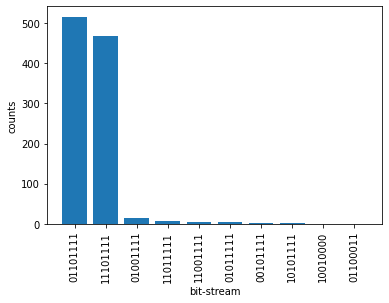

In [3]:
# Get up to 10 bitstreams with highest counts
qp.printStats(rx, msgHat, msg, k=10, histogram=True)


## Showing the Quantum Polar Decoder circuit
Now we can use Qiskit's ``draw`` method to draw the circuit. The three parts of the circuit separated by the barrier lines show the **Quantum Soft Decision**, **Quantum Generator**, and the measurement gates as explained in the paper. 

Circuit Depth: 6


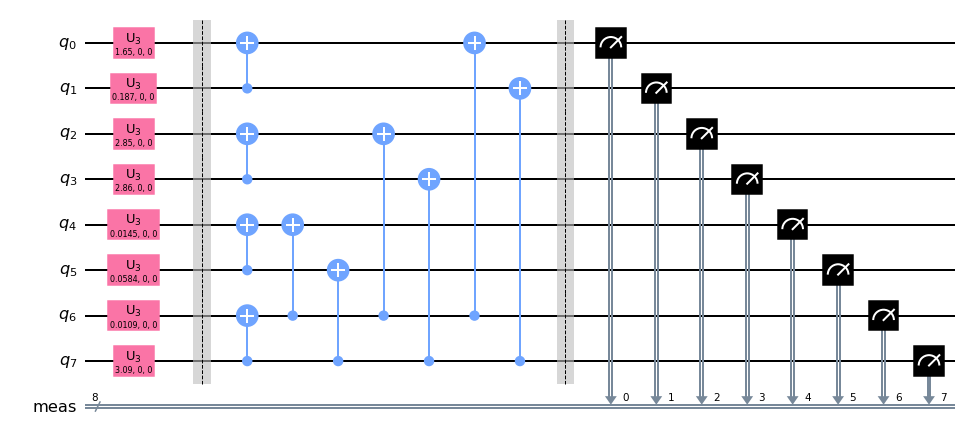

In [4]:
print("Circuit Depth:",qp.circuit.depth())
qp.circuit.decompose().decompose().draw(output='mpl')